# 1. Configuración de la sesión Spark

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("OrderLinesBatchProcessing") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .getOrCreate()


print("✅ Spark Session creada")
print(f"Versión de Spark: {spark.version}")

✅ Spark Session creada
Versión de Spark: 3.5.0


# 2. Lectura de Datos (Filtro por Partición)

In [7]:
schema = StructType([
    StructField("sensor_id", StringType(), True),
    StructField("humidity", DoubleType(), True),
    StructField("timestamp", TimestampType(), True),
    StructField("location", StringType(), True),
    StructField("unix_ts", StringType(), True),
    StructField("partition", StringType(), True)
])

In [8]:
# Leemos el bucket de humedad
df_hum = spark.read.schema(schema).csv("s3a://humidity-sensors/")

# Verificamos los datos cargados
df_hum.show(5)

+---------+--------+-------------------+-----------+-------------+---------+
|sensor_id|humidity|          timestamp|   location|      unix_ts|partition|
+---------+--------+-------------------+-----------+-------------+---------+
|   HUM_01|   42.07|2025-04-11 07:00:00|Warehouse_A|1744354800000|        0|
|   HUM_01|   44.25|2025-04-11 07:15:00|Warehouse_A|1744355700000|        0|
|   HUM_01|   42.73|2025-04-11 07:30:00|Warehouse_A|1744356600000|        0|
|   HUM_01|   43.05|2025-04-11 07:45:00|Warehouse_A|1744357500000|        0|
|   HUM_01|   42.91|2025-04-11 08:00:00|Warehouse_A|1744358400000|        0|
+---------+--------+-------------------+-----------+-------------+---------+
only showing top 5 rows



# 3. Cálculo de Métricas por hora

In [9]:
# Extraemos la hora y calculamos el promedio
from pyspark.sql.functions import hour, col, avg, round

df_hourly_hum = df_hum.withColumn("hora_dia", hour(col("timestamp"))) \
    .groupBy("hora_dia") \
    .agg(round(avg("humidity"), 2).alias("humedad_media")) \
    .orderBy("hora_dia")

df_hourly_hum.show(24)

+--------+-------------+
|hora_dia|humedad_media|
+--------+-------------+
|       0|        64.79|
|       1|        64.58|
|       2|        65.37|
|       3|        64.69|
|       4|        65.05|
|       5|        65.17|
|       6|        45.06|
|       7|        44.58|
|       8|        45.08|
|       9|        45.48|
|      10|        44.93|
|      11|        44.93|
|      12|         45.1|
|      13|        44.79|
|      14|        45.13|
|      15|         45.3|
|      16|        45.01|
|      17|        45.07|
|      18|         65.7|
|      19|        65.07|
|      20|        64.99|
|      21|        64.97|
|      22|         65.0|
|      23|        64.59|
+--------+-------------+



# 4. Visualización de la Tendencia

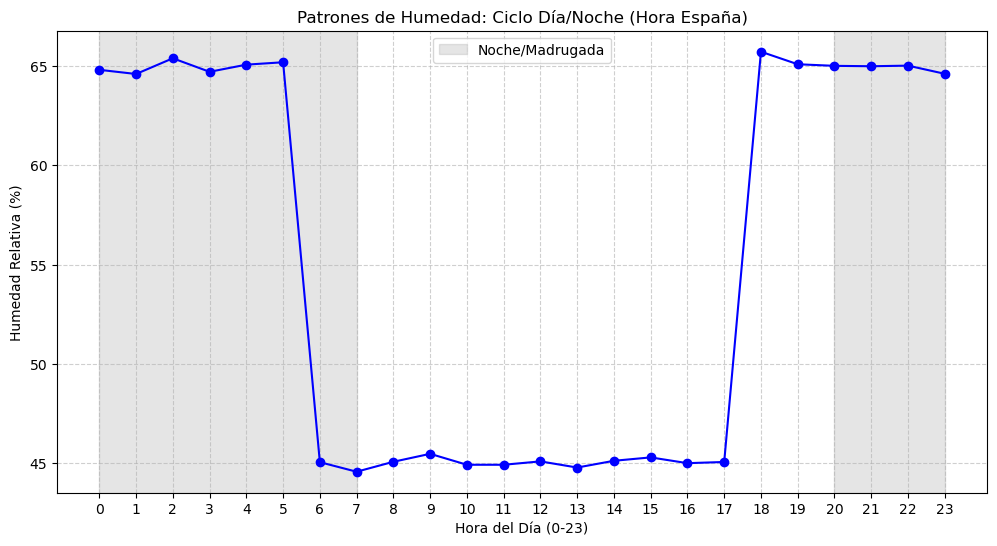

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir a Pandas para graficar
pdf_hum = df_hourly_hum.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pdf_hum['hora_dia'], pdf_hum['humedad_media'], color='blue', marker='o', linestyle='-')

# Añadir sombreado para representar la noche 
plt.axvspan(0, 7, color='gray', alpha=0.2, label='Noche/Madrugada')
plt.axvspan(20, 23, color='gray', alpha=0.2)

plt.title("Patrones de Humedad: Ciclo Día/Noche (Hora España)")
plt.xlabel("Hora del Día (0-23)")
plt.ylabel("Humedad Relativa (%)")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()